### imports ###

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os, sys
import seaborn as sns
from scipy.stats import pearsonr
import mdtraj as md 
import numpy as np 
import os, sys 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colorbar import ColorbarBase

In [28]:
def source_module(module_file: str, local_module_name: str = None):
    import importlib
    """to add a module from a user defined python script into the local name space"""
    if local_module_name is None:
        local_module_name = module_file.split("/")[-1].replace(".py", "")
    if len(module_file.split("/")) == 1 or module_file.split("/")[-2] == ".":
        module_dir = os.getcwd()
    else:
        module_dir = "/".join(module_file.split("/")[:-1])
    sys.path.insert(0, module_dir)
    module = importlib.import_module(module_file.split("/")[-1].replace(".py", ""))
    g = globals()
    g[local_module_name] = module
    pass

# importing a python script where I keep a lot of the basic functions I use!
source_module("/Users/anjalidhar/Desktop/Packages/mdtools.py")
source_module("/Users/anjalidhar/Desktop/Packages/Writhe_Package/package/visualize/visualize.py")

from visualize import palettes
labels = mdtools.load_dict(f'/Users/anjalidhar/Desktop/Packages/run_label_dict')

## Loading ##

In [24]:
docking_scores_ = {}
score_dir = '/Users/anjalidhar/Desktop/docking_paper/github/data/docking_scores' 
runs = ['41on41bf', '47on47bf', '41onapo', '47onapo', '23onapo']
for d in ['AD', 'DD']:
    docking_scores_[d]={}
    for run in runs: 
        docking_scores_[d][run] = np.load(f'/Users/anjalidhar/Desktop/docking_paper/github/data/docking_scores/{d}_{run}.npy')

In [27]:
# 23bf is gross bc the frame #s are not homogenous; we cannot stack them 
for d in ['AD', 'DD']:
    docking_scores_[d]['23on23bf'] = []
    for i in range(20):
        s = np.load(f'/Users/anjalidhar/Desktop/docking_paper/github/data/docking_scores/{d}_23on23bf/c_{i}.npy')
        docking_scores_[d]['23on23bf'].append(s)

In [12]:
angledir = '/Users/anjalidhar/Desktop/autodock/trajectory_bendangles'
angles = {}
traj_type = ['apo', '47bf', '41bf', '23bf']
for traj in traj_type: 
    angles[traj] = np.load(f'{angledir}/{traj}_angles.npy')

### Boot strapping the angles~ ###

In [32]:
def calculate_angle(A, B, C):
    """
    Calculate the angle ABC (in degrees) where A, B, and C are points in 3D space.
    
    Parameters:
    A, B, C : array-like
        3D coordinates of the points.
    
    Returns:
    angle : float
        The angle ABC in degrees.
    """
    
    # Convert points to numpy arrays
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)
    
    # Define vectors AB and BC
    AB = A - B
    BC = C - B
    
    # Calculate the dot product of AB and BC
    dot_product = np.dot(AB, BC)
    
    # Calculate the magnitudes of AB and BC
    magnitude_AB = np.linalg.norm(AB)
    magnitude_BC = np.linalg.norm(BC)
    
    # Calculate the cosine of the angle using the dot product formula
    cos_theta = dot_product / (magnitude_AB * magnitude_BC)
    
    # Ensure the cosine value is within the valid range to avoid numerical issues
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    
    # Calculate the angle in radians
    angle_radians = np.arccos(cos_theta)
    
    # Convert the angle to degrees
    angle_degrees = np.degrees(angle_radians)
    
    return angle_degrees

def calculate_angle_slice(slice):
    """
    Calculate the angle between three 3D points in a slice of shape (3, 3).

    Parameters:
    slice : array-like
        A slice of shape (3, 3) representing three 3D coordinates.

    Returns:
    angle : float
        The angle ABC in degrees.
    """
    A, B, C = slice
    return calculate_angle(A, B, C)

In [43]:
all_angs = []
for j in range(20):
    trj = trajs['MD']['41bf_sel'][j]
    ca = trj.atom_slice(trj.top.select('name CA and (resid 0 or resid 9 or resid 19)'))
    clus_angs = []
    for i in range(1001): 
        clus_angs.append(calculate_angle_slice(ca.xyz[i]))
    all_angs.append(clus_angs)


In [47]:
angs_41bf = np.array(all_angs)

In [52]:
import scipy.stats as stats
def ci(x, iv:float=0.95):
    
    l,r = stats.t.interval(confidence=iv,df = len(x)-1, loc = 0, scale=stats.sem(x))
    return (abs(l)+abs(r))/2

def boot_ci(x,iv=.95,n_resamples=10000,fxn=np.mean, axis=0):
    mean = fxn(x)
    x = (x,)
    l,r = stats.bootstrap(data=x,statistic=fxn,confidence_level = iv,n_resamples=n_resamples,
                           method="percentile",vectorized=True,axis=axis).confidence_interval
    l,r = [i-mean for i in [l,r]]
    return (abs(l)+abs(r))/2

In [53]:
ang_uncert = np.array([boot_ci(ang, iv=.95, n_resamples=10000, fxn=np.mean, axis=0) for ang in angs_41bf]) # shape (20,)
        

## Figures ##

In [14]:
def get_trajtype(name): 
    if 'apo' in name: 
        return 'apo'
    else: 
        return name[-4:]

### holo vs apo docking... ###

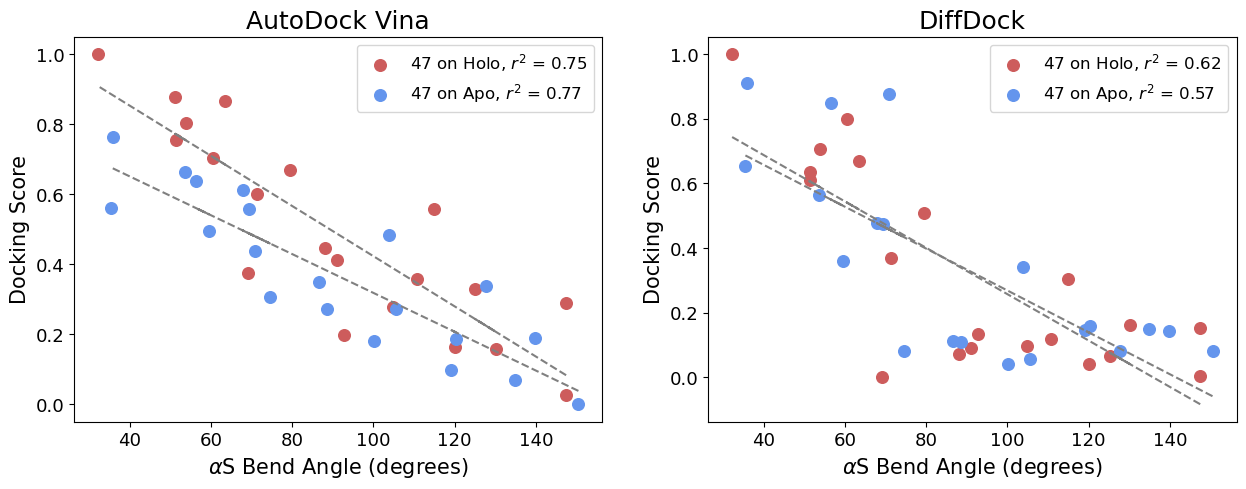

In [14]:
# idea: we're normalizing after we take the mean so we get a nice thing from 0 to 1. finding the combined 
# min and max for ligand 41 and 47 so they maintain their difference that we see before. 
def min_max_norm(data, min_val, max_val):
    return (data - min_val) / (max_val - min_val)

AD_or_DD_str = ["AD", "DD"]
runs = ['47on47bf', '47onapo']
fig, axes = plt.subplots(1, len(AD_or_DD_str), figsize=(15, 5), sharey=False, sharex=True)

for i, ax in enumerate(axes.flat):
    ax.tick_params(axis='both', labelsize=13)
    scores = [docking_scores[AD_or_DD_str[i]][run].mean(1) for run in runs]

    if AD_or_DD_str[i] =='AD': 
        scores = [-score for score in scores]

    comb_min = min([np.min(score) for score in scores])
    comb_max = max([np.max(score) for score in scores])

    for j, (run,score) in enumerate(zip(runs,scores)): 
        norm_score = min_max_norm(score, comb_min, comb_max)

        # we should be able to do this exact transformation on the raw uncertainties to get the normalized uncertainties


        traj_type = get_trajtype(run)
        ang = angles[traj_type]

        # Calculating the linear regression and correlation coefficient
        ndict = mdtools.PolyRegression1D(ang, norm_score, degree=1, intercept=True)[0]

        ax.scatter(ang, norm_score, label=['47 on Holo, ', '47 on Apo, '][j] + rf"$r^{2}$ = {ndict['r2']:.2f}",
                   color=['indianred', 'cornflowerblue'][j], s=70)
        ax.plot(ang, ndict['ypred'], ls="--", color="grey")
        ax.legend(fontsize=12, loc='upper right')

        ax.set_ylabel('Docking Score', fontsize=15)
        ax.set_xlabel(r'$\alpha$S Bend Angle (degrees)', fontsize=15)

        ax.set_title(['AutoDock Vina', 'DiffDock'][i], fontsize=18)

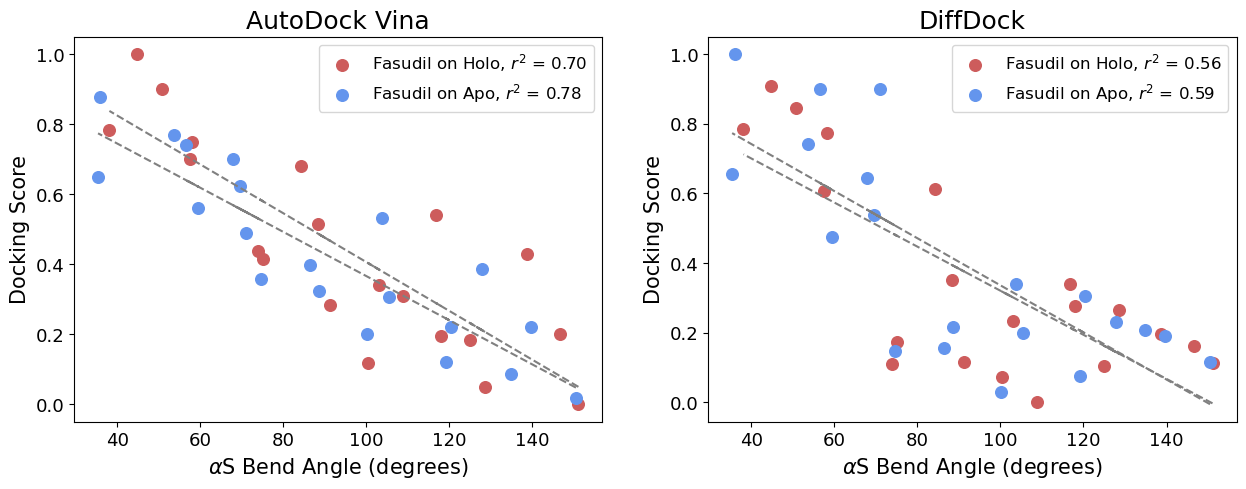

In [15]:
# idea: we're normalizing after we take the mean so we get a nice thing from 0 to 1. finding the combined 
# min and max for ligand 41 and 47 so they maintain their difference that we see before. 
def min_max_norm(data, min_val, max_val):
    return (data - min_val) / (max_val - min_val)

AD_or_DD_str = ["AD", "DD"]
runs = ['41on41bf', '41onapo']
fig, axes = plt.subplots(1, len(AD_or_DD_str), figsize=(15, 5), sharey=False, sharex=True)

for i, ax in enumerate(axes.flat):
    ax.tick_params(axis='both', labelsize=13)
    scores = [docking_scores[AD_or_DD_str[i]][run].mean(1) for run in runs]

    if AD_or_DD_str[i] =='AD': 
        scores = [-score for score in scores]

    comb_min = min([np.min(score) for score in scores])
    comb_max = max([np.max(score) for score in scores])

    for j, (run,score) in enumerate(zip(runs,scores)): 
        norm_score = min_max_norm(score, comb_min, comb_max)

        # we should be able to do this exact transformation on the raw uncertainties to get the normalized uncertainties


        traj_type = get_trajtype(run)
        ang = angles[traj_type]

        # Calculating the linear regression and correlation coefficient
        ndict = mdtools.PolyRegression1D(ang, norm_score, degree=1, intercept=True)[0]

        ax.scatter(ang, norm_score, label=['Fasudil on Holo, ', 'Fasudil on Apo, '][j] + rf"$r^{2}$ = {ndict['r2']:.2f}",
                   color=['indianred', 'cornflowerblue'][j], s=70)
        ax.plot(ang, ndict['ypred'], ls="--", color="grey")
        ax.legend(fontsize=12, loc='upper right')

        ax.set_ylabel('Docking Score', fontsize=15)
        ax.set_xlabel(r'$\alpha$S Bend Angle (degrees)', fontsize=15)

        ax.set_title(['AutoDock Vina', 'DiffDock'][i], fontsize=18)

### Boot strapping to find if 41 and 47 are statistically significantly different ###

In [14]:
import scipy.stats as stats
def ci(x, iv:float=0.95):
    
    l,r = stats.t.interval(confidence=iv,df = len(x)-1, loc = 0, scale=stats.sem(x))
    return (abs(l)+abs(r))/2

def boot_ci(x,iv=.95,n_resamples=10000,fxn=np.mean, axis=0):
    mean = fxn(x)
    x = (x,)
    l,r = stats.bootstrap(data=x,statistic=fxn,confidence_level = iv,n_resamples=n_resamples,
                           method="percentile",vectorized=True,axis=axis).confidence_interval
    l,r = [i-mean for i in [l,r]]
    return (abs(l)+abs(r))/2

In [15]:
uncertainties = {}
programs = ['AD', 'DD']
runs = ['47on47bf', '41on41bf', '23on23bf', '47onapo', '41onapo', '23onapo']

for pr in programs: 
    uncertainties[pr] ={}
    for run in runs: 
        scores = [x for x in docking_scores[pr][run]] # list of cluster scores 
        uncertainties[pr][run] = np.array([boot_ci(score, iv=.95, n_resamples=10000, 
                                                   fxn=np.mean, axis=0) for score in scores]) # shape (20,)
        
        

# ALL LIGANDS: Figure with uncertainty #

For holo data: 

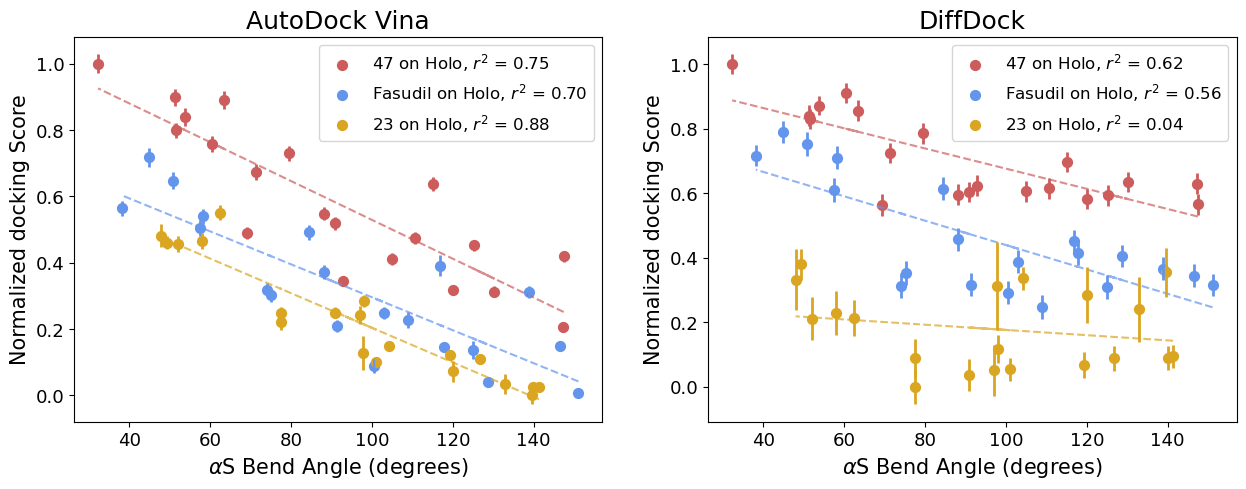

In [21]:

def min_max_norm(data, min_val, max_val):
    return (data - min_val) / (max_val - min_val)

AD_or_DD_str = ["AD", "DD"]
runs = ['47on47bf', '41on41bf', '23on23bf']
fig, axes = plt.subplots(1, len(AD_or_DD_str), figsize=(15, 5), sharey=False, sharex=True)

for i, ax in enumerate(axes.flat):
    ax.tick_params(axis='both', labelsize=13)
    scores = [np.array([np.mean(x) for x in docking_scores[AD_or_DD_str[i]][run]]) for run in runs]

    if AD_or_DD_str[i] =='AD': 
        scores = [-score for score in scores]

    comb_min = min([np.min(score) for score in scores])
    comb_max = max([np.max(score) for score in scores])

    for j, (run,score) in enumerate(zip(runs,scores)): 
        norm_score = min_max_norm(score, comb_min, comb_max)
        uncert = uncertainties[AD_or_DD_str[i]][run]
        norm_uncert = uncert/ (comb_max-comb_min)

        # we should be able to do this exact transformation on the raw uncertainties to get the normalized uncertainties


        traj_type = get_trajtype(run)
        ang = angles[traj_type]

        # Calculating the linear regression and correlation coefficient
        ndict = mdtools.PolyRegression1D(ang, norm_score, degree=1, intercept=True)[0]

        ax.scatter(ang, norm_score, 
                   label=['47 on Holo, ', 'Fasudil on Holo, ', '23 on Holo, '][j] + rf"$r^{2}$ = {ndict['r2']:.2f}",
                   color=['indianred', 'cornflowerblue', 'goldenrod'][j], s=50)
        ax.errorbar(ang, norm_score, yerr=norm_uncert, fmt='none',
                     color=['indianred', 'cornflowerblue', 'goldenrod'][j], alpha=1, lw=2)
        
        ax.plot(ang, ndict['ypred'], ls="--", lw=1.5,color=['indianred', 'cornflowerblue', 'goldenrod'][j], alpha=0.7)
        ax.legend(fontsize=12, loc='upper right')

        ax.set_ylabel('Normalized docking Score', fontsize=15)
        ax.set_xlabel(r'$\alpha$S Bend Angle (degrees)', fontsize=15)

        ax.set_title(['AutoDock Vina', 'DiffDock'][i], fontsize=18)

plt.savefig(f'/Users/anjalidhar/Desktop/score_bend_angle.png', dpi=300, bbox_inches='tight')

For apo docking: 

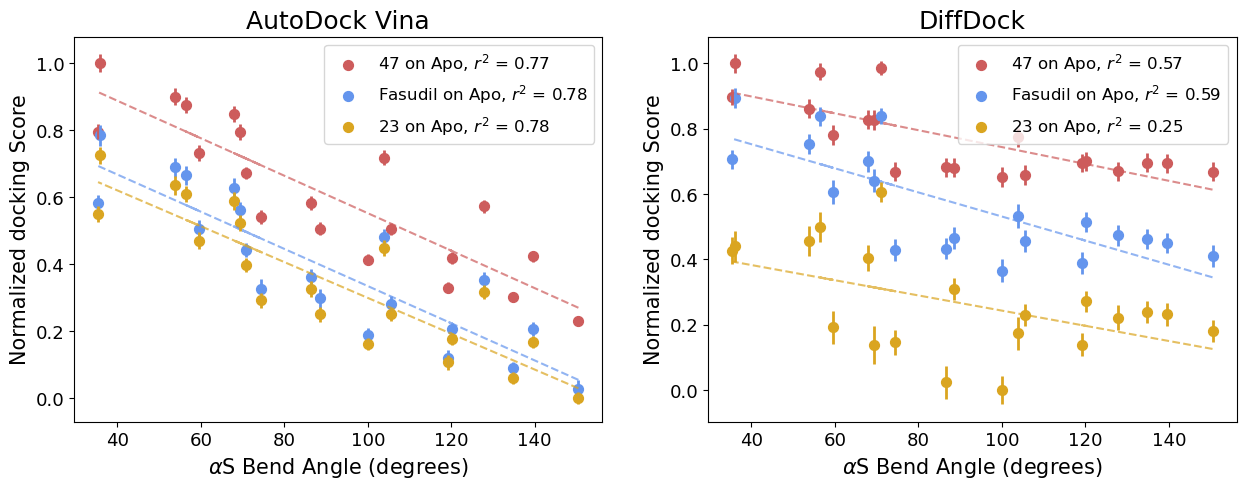

In [22]:
def min_max_norm(data, min_val, max_val):
    return (data - min_val) / (max_val - min_val)

AD_or_DD_str = ["AD", "DD"]
runs = ['47onapo', '41onapo', '23onapo']
fig, axes = plt.subplots(1, len(AD_or_DD_str), figsize=(15, 5), sharey=False, sharex=True)

for i, ax in enumerate(axes.flat):
    ax.tick_params(axis='both', labelsize=13)
    scores = [np.array([np.mean(x) for x in docking_scores[AD_or_DD_str[i]][run]]) for run in runs]

    if AD_or_DD_str[i] =='AD': 
        scores = [-score for score in scores]

    comb_min = min([np.min(score) for score in scores])
    comb_max = max([np.max(score) for score in scores])

    for j, (run,score) in enumerate(zip(runs,scores)): 
        norm_score = min_max_norm(score, comb_min, comb_max)
        uncert = uncertainties[AD_or_DD_str[i]][run]
        norm_uncert = uncert/ (comb_max-comb_min)

        # we should be able to do this exact transformation on the raw uncertainties to get the normalized uncertainties


        traj_type = get_trajtype(run)
        ang = angles[traj_type]

        # Calculating the linear regression and correlation coefficient
        ndict = mdtools.PolyRegression1D(ang, norm_score, degree=1, intercept=True)[0]

        ax.scatter(ang, norm_score, 
                   label=['47 on Apo, ', 'Fasudil on Apo, ', '23 on Apo, '][j] + rf"$r^{2}$ = {ndict['r2']:.2f}",
                   color=['indianred', 'cornflowerblue', 'goldenrod'][j], s=50)
        ax.errorbar(ang, norm_score, yerr=norm_uncert, fmt='none',
                     color=['indianred', 'cornflowerblue', 'goldenrod'][j], alpha=1, lw=2)
        
        ax.plot(ang, ndict['ypred'], ls="--", lw=1.5,color=['indianred', 'cornflowerblue', 'goldenrod'][j], alpha=0.7)
        ax.legend(fontsize=12, loc='upper right')

        ax.set_ylabel('Normalized docking Score', fontsize=15)
        ax.set_xlabel(r'$\alpha$S Bend Angle (degrees)', fontsize=15)

        ax.set_title(['AutoDock Vina', 'DiffDock'][i], fontsize=18)

plt.savefig(f'/Users/anjalidhar/Desktop/score_bend_angle_apo.png', dpi=300, bbox_inches='tight')

## Now, trying to compare docking score to MD bound fraction... ##

In [37]:
bound_frac = {}
for run in ['41', '47', '23']: 
    bound_frac[run] = np.load(f'/Users/anjalidhar/Desktop/docking_paper/github/data/bound_frac/{run}bf.npy')

Text(0.5, 0, 'MD Bound Fraction')

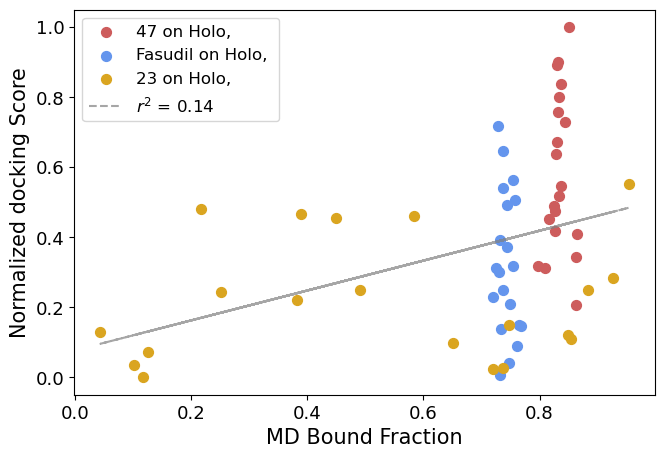

In [20]:
def min_max_norm(data, min_val, max_val):
    return (data - min_val) / (max_val - min_val)

AD_or_DD_str = ["AD"]
runs = ['47on47bf', '41on41bf', '23on23bf']
runs2 = ['47', '41', '23']
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5), sharey=False, sharex=True)
i = 0 

ax.tick_params(axis='both', labelsize=13)
scores = [np.array([np.mean(x) for x in docking_scores[AD_or_DD_str[i]][run]]) for run in runs]

if AD_or_DD_str[i] =='AD': 
    scores = [-score for score in scores]

comb_min = min([np.min(score) for score in scores])
comb_max = max([np.max(score) for score in scores])

all_mdbf = np.array([x for x in bound_frac['47']]+[x for x in bound_frac['41']]+[x for x in bound_frac['23']])
all_nscore = np.array([x for x in min_max_norm(scores[0], comb_min, comb_max)]+[x for x in min_max_norm(scores[1], comb_min, comb_max)]+[x for x in min_max_norm(scores[2], comb_min, comb_max)])

for j, (run,score) in enumerate(zip(runs,scores)): 
    norm_score = min_max_norm(scores, comb_min, comb_max)
    # uncert = uncertainties[AD_or_DD_str[i]][run]
    # norm_uncert = uncert/ (comb_max-comb_min)

    # we should be able to do this exact transformation on the raw uncertainties to get the normalized uncertainties

    traj_type = get_trajtype(run)
    mdbf = bound_frac[runs2[j]]


    # Calculating the linear regression and correlation coefficient
    ndict = mdtools.PolyRegression1D(all_mdbf, all_nscore, degree=1, intercept=True)[0]

    ax.scatter(mdbf, norm_score[j], 
                label=['47 on Holo, ', 'Fasudil on Holo, ', '23 on Holo, '][j], #+ rf"$r^{2}$ = {ndict['r2']:.2f}",
                color=['indianred', 'cornflowerblue', 'goldenrod'][j], s=50)
    # ax.errorbar(ang, norm_score, yerr=norm_uncert, fmt='none',
    #                 color=['indianred', 'cornflowerblue', 'goldenrod'][j], alpha=1, lw=2)
    
ax.plot(all_mdbf, ndict['ypred'], ls="--", lw=1.5,color='grey', alpha=0.7, label=rf"$r^{2}$ = {ndict['r2']:.2f}")
ax.legend(fontsize=12, loc='upper left')

ax.set_ylabel('Normalized docking Score', fontsize=15)
ax.set_xlabel(r'MD Bound Fraction', fontsize=15)

# ax.set_title(['AutoDock Vina'][i], fontsize=18)



Checking to see if MD bound fraction is even correlated with cluster bend angle at all: 

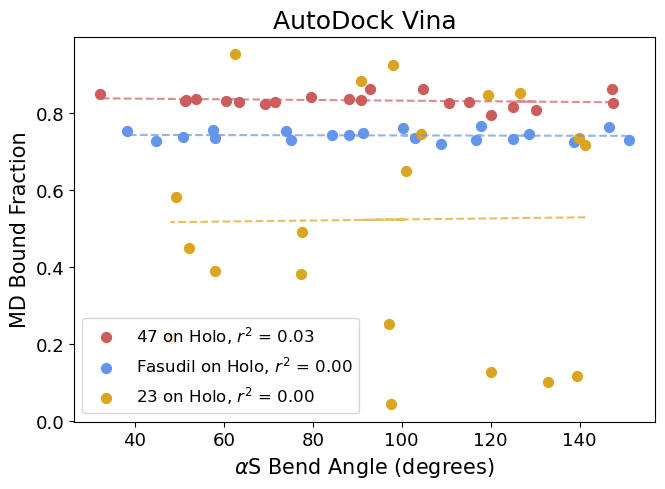

In [23]:
def min_max_norm(data, min_val, max_val):
    return (data - min_val) / (max_val - min_val)

AD_or_DD_str = ["AD"]
runs = ['47on47bf', '41on41bf','23on23bf']
runs2 = ['47', '41', '23']
fig, ax = plt.subplots(1, 1, figsize=(7.5, 5), sharey=False, sharex=True)
i = 0 

ax.tick_params(axis='both', labelsize=13)




for j, (run,score) in enumerate(zip(runs,scores)): 


    traj_type = get_trajtype(run)
    mdbf = bound_frac[runs2[j]]
    ang = angles[traj_type]

    # Calculating the linear regression and correlation coefficient
    ndict = mdtools.PolyRegression1D(ang,mdbf, degree=1, intercept=True)[0]

    ax.scatter(ang, mdbf,
                label=['47 on Holo, ', 'Fasudil on Holo, ', '23 on Holo, '][j] + rf"$r^{2}$ = {ndict['r2']:.2f}",
                color=['indianred', 'cornflowerblue', 'goldenrod'][j], s=50)
    # ax.errorbar(ang, norm_score, yerr=norm_uncert, fmt='none',
    #                 color=['indianred', 'cornflowerblue', 'goldenrod'][j], alpha=1, lw=2)
    
    ax.plot(ang, ndict['ypred'], ls="--", lw=1.5,color=['indianred', 'cornflowerblue', 'goldenrod'][j], alpha=0.7)
    ax.legend(fontsize=12, loc='lower left')

    ax.set_xlabel(r'$\alpha$S Bend Angle (degrees)', fontsize=15)
    ax.set_ylabel(r'MD Bound Fraction', fontsize=15)

    ax.set_title(['AutoDock Vina'][i], fontsize=18)

